In [2]:
import torch
import numpy as np

Let's get familiar with some of torch's commands.

In [3]:
x_torch= torch.rand(3,3)
x_torch
# x_np = np.random.rand(3,3)
# x_np

tensor([[0.8542, 0.2789, 0.5361],
        [0.3017, 0.8755, 0.2555],
        [0.5928, 0.2469, 0.9477]])

### What is .backward() ??

In [59]:
# x = torch.randn(3, requires_grad=True)
x = torch.tensor([1.0,1,1], requires_grad=True) # torch.tensor([1,1,1], requires_grad=True) is error due to type 
x

tensor([1., 1., 1.], requires_grad=True)

In [60]:
# backward() accumulates the gradient multiple evaluation of the cell changes the result:
y = x*x+2
z = y.sum()
z.backward()
print(x.grad)

tensor([2., 2., 2.])


In [61]:
# we can help it to zero gradient we can use:
x.grad.data.zero_()

tensor([0., 0., 0.])

In [62]:
# this time we have the same result
y = x*x+2
z = y.sum()
if x.grad is None:
    # before the first call .backward(), x.grad is None
    z.backward()
else:
    x.grad.data.zero_()
    z.backward()
print(x.grad)

tensor([2., 2., 2.])


In [63]:
a = torch.arange(start=0, end=2*np.pi, step=0.2, requires_grad=True)
b = torch.sin(a)
b.backward(torch.arange(32)) # b.backward() result in error
a.grad

tensor([  0.0000,   0.9801,   1.8421,   2.4760,   2.7868,   2.7015,   2.1741,
          1.1898,  -0.2336,  -2.0448,  -4.1615,  -6.4735,  -8.8487, -11.1396,
        -13.1911, -14.8499, -15.9727, -16.4356, -16.1417, -15.0284, -13.0729,
        -10.2955,  -6.7613,  -2.5795,   2.1000,   7.0916,  12.1814,  17.1367,
         21.7159,  25.6801,  28.8051,  30.8928])

```b``` depends on ```a```
$$\mathbb{R}^{32}\ni \texttt{a}=\left( x_0, x_1, \ldots, x_{31}\right) 
\overset{b}{\longrightarrow} 
\left(\sin(x_0),\sin(x_1), \ldots,\sin(x_{31})\right)=\texttt{b}(\texttt{a})\in\mathbb{R}^{32} $$
the line ```b.backward(v)``` can be interpreted computing:
$$
\partial_{\texttt{v}}\texttt{b}(\texttt{a}) = D\texttt{b}(\texttt{a})(\texttt{v})=D\texttt{b}(\texttt{a})\cdot\texttt{v},\text{ where } 
D\texttt{b}(\texttt{a})\in \mathcal{L}(T_a\mathbb{R}^{32},T_{b(a)}\mathbb{R}^{32}) \simeq M_{32\times 32}(\mathbb{R})$$


In [64]:
# and indeed:
np.cos(a[-1].detach())*31 == a.grad[-1]

tensor(True)

In [78]:
t = torch.ones(4, 4,requires_grad=True)
m, m[0,0], m[3,3] = torch.eye(4), 0, 0
s = torch.matmul(t,m) * torch.matmul(m,t)
print(f"{s.detach().numpy()} \n =\n{torch.matmul(t,m).detach().numpy()}\n multiplied by \n{torch.matmul(m,t).detach().numpy()}")
u = s.sum()
u.backward()
t.grad

[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]] 
 =
[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]]
 multiplied by 
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


tensor([[0., 0., 0., 0.],
        [0., 2., 2., 0.],
        [0., 2., 2., 0.],
        [0., 0., 0., 0.]])

Read more [here](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html)

### Labeled data load:
Cells below is almost [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) but insead of FashionMNIST, data from MNIST is loaded.

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [155]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,    #True if not dowloaded
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,    #True if not dowloaded
    transform=ToTensor()
)

9


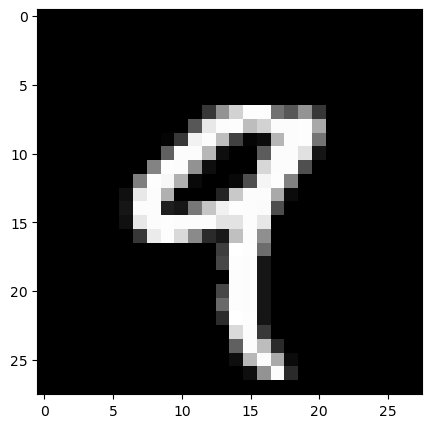

In [8]:
# preview data by choosing i-th element form dataset:
ith = 4
figure = plt.figure(figsize=(5, 5))
img, label = training_data[ith]
print(label)
plt.imshow(img.squeeze(), cmap="gray") # .squeeze() like in numpy it removes axes with dimention 1 i.e. [[[[1],[2]],[[3],[4]],[[5],[6]]]] ->[[,],[,],[]]
plt.show()

In [130]:
# dictionary of strings, in code below str(label) would also work, but for categorical data e.g. FashionMNIST dict is useful.
labels_map = {i : str(i) for i in range(10)}

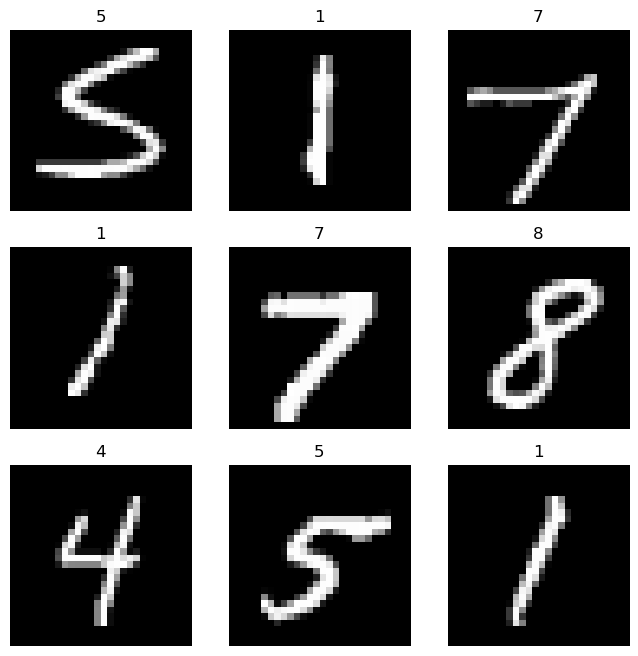

In [119]:
# example of accessing pairs of (image,lable)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() 
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [31]:
# Every picture is this many numbers:
print(np.prod(img.shape))

784


In [156]:
#data from training_data and test_data for traning. Here splitting into batches and shuffling is taken care of.
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

# appointing the hardwere
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# for i, (images, labels) in enumerate(train_dataloader):
#     images, labels = images.to(device), labels.to(device)
#     if i % 100 ==0:
#         print(labels.device)
        
# for i, (images, labels) in enumerate(train_dataloader):
#     if i % 100 ==0:
#         print(labels.device)

AttributeError: 'MNIST' object has no attribute 'to'

In [133]:
# when we touch "touched" the above DataLoader(...) returns a list of two tensors:
# [ tesnor( data_0, data_1, data_2...,databatch_size ), tensor(label_0,label_1,...,label_batch_size)]
# this is will be used in traning loop.

for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch number is {batch}\n")
    print(f"Shape of data tensor in the batch = {X.size()}\n")
    print(f"The labels is another tesor = {y}")
    if batch == 0:
        break
# for batch, el in enumerate(train_dataloader):
#     print(el)
#     if batch == 1:
#         break

Batch number is 0

Shape of data tensor in the batch = torch.Size([100, 1, 28, 28])

The labels is another tesor = tensor([7, 3, 0, 2, 8, 0, 6, 3, 9, 3, 5, 3, 3, 9, 8, 2, 9, 8, 2, 6, 7, 1, 6, 4,
        2, 3, 8, 3, 8, 3, 4, 8, 5, 1, 0, 5, 5, 6, 9, 4, 9, 7, 4, 1, 3, 4, 0, 0,
        7, 2, 2, 4, 3, 9, 3, 3, 0, 4, 4, 9, 2, 2, 7, 4, 0, 1, 2, 0, 9, 8, 3, 4,
        9, 3, 9, 4, 3, 3, 8, 1, 3, 0, 3, 9, 8, 6, 8, 2, 6, 9, 6, 4, 1, 3, 2, 9,
        6, 2, 5, 3])


Notice that return of a DataLoader(...) is an iterable and with every "touch" function ```next``` is called.\
Therefore evaluation of the above cell ruins the variable ```train_dataloader``` as
the pointer is not on the first element of the data.

In [32]:
# appointing the hardwere
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Our small Neural Network
Below we define class: ```NeuralNetwork``` which will be our small model.\
For curious there is something about function [super](https://stackoverflow.com/a/33469090) and [how](https://en.wikipedia.org/wiki/C3_linearization) MRO (Method Resolution Order) works in python.

In [169]:
import os
from torch import nn
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        # call __init__ from the parent class: nn.Module.
        super(NeuralNetwork, self).__init__()
        
        # this flattens the images in the batch to the 1d tensors suitabe for nn.Sequential
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 16),  #  input -> 1st layer  = first hidden layer  16 neurons. (like matrix of shape: 16 x 784)
            nn.ReLU(),             # ReLU activation funtion at 16 neurons of the 1st layer
            nn.Linear(16, 16),     # 1st layer -> 2nd layer = second hidden layer with 16 neurons
            nn.ReLU(),             # ReLU activation funtion at 16 neurons of the 2nd layer
            nn.Linear(16, 10),     # 2nd layer -> output 
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x.to('cuda'))
        return logits

We can preview the structure of the model:

In [170]:
model = NeuralNetwork().to(device) 
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


We can put some random data through our model and observe the result.

In [171]:
X = torch.rand(1, 28, 28, device=device) # random image
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
print(f"Our neural network is a function and the output on random data X is \n{logits}")
print(f"\nBelow there is nn.Softmax normalization of numbers on last layer\n{pred_probab}")
print()
print(f"Predicted class: {pred_probab.argmax(1)}")
print() # or use torch.argmax
# print(f"Predicted class: {torch.argmax(pred_probab, dim=1)}")    # the same as above
print(f"Predicted class: {torch.argmax(pred_probab, dim=1)[0]}")

Our neural network is a function and the output on random data X is 
tensor([[-0.1423,  0.1831, -0.1042, -0.0579,  0.2345, -0.1184, -0.0876,  0.1150,
          0.0955, -0.1981]], device='cuda:0', grad_fn=<AddmmBackward0>)

Below there is nn.Softmax normalization of numbers on last layer
tensor([[0.0865, 0.1198, 0.0899, 0.0941, 0.1261, 0.0886, 0.0914, 0.1119, 0.1098,
         0.0818]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Predicted class: tensor([4], device='cuda:0')

Predicted class: 4


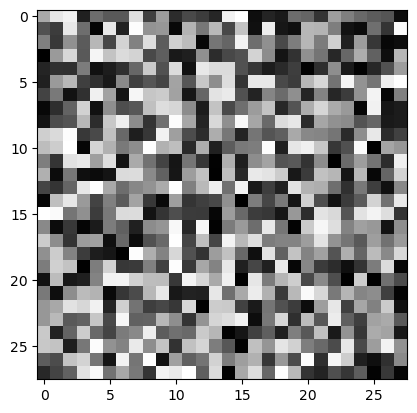

In [57]:
# This is input X:
fig, ax = plt.subplots()
ax.imshow(X.squeeze().cpu() , cmap="gray")
plt.show()

### The parameters
nn.Module takes care of the paremters in linear transformations and ReLUs.\
How to access NeuralNetwork named_parameters:\
(there are also .parameters)

In [109]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([16, 784]) | Values : tensor([[-0.0347,  0.0283, -0.0079,  ...,  0.0174, -0.0122, -0.0234],
        [ 0.0143,  0.0267, -0.0176,  ...,  0.0023,  0.0298,  0.0029]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([16]) | Values : tensor([-0.0033, -0.0179], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([16, 16]) | Values : tensor([[ 0.1361,  0.1447, -0.0661,  0.2239, -0.2124, -0.0215, -0.2278,  0.0455,
          0.0122,  0.0697, -0.1572,  0.0639, -0.1251,  0.0710,  0.1620,  0.0727],
        [ 0.0561,  0.1798,  0.0359, -0.2381, -0.0071, -0.1452,  0.0364, -0.1397,
         -0.2334, -0.2272, -0.2142,  0.0860, -0.1515,  0.0232, -0.2425,  0.2452]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([16]) | Values : tensor([-0.1498,  0.0056], device='cuda:0', grad_fn=<SliceBackward0>) 


#### Some constants, called  ***hyperparameters*** - we do not minimize over those :P
In torch tutorial there are some [examples](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#hyperparameters) of hyperparameters.
They do not change at traning step. We can change them at the step called ***Refine model***.\
Not final reading but with a nice graf representation of the process appears in section [Basic principles of machine learning](https://www.nature.com/articles/s41524-019-0221-0#Sec2).

In [183]:
# learning_rate = 1e-2    # later
learning_rate = 1e-3
batch_size = 100
epochs = 5

train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

### Loss Function
With the loss function we almost complete the NN (as  $\mathbb{R}^n\rightarrow \mathbb{R}$ function). There is a matrix input and a single number output that represents if we have something to compare with.\
Good start for some introduction mathematical [wikipedia surfing](https://en.wikipedia.org/wiki/Cross_entropy).

In [173]:
loss_fn = nn.CrossEntropyLoss()

### Training
i.e. try to find parameters minimising loss function on ***batches of traning data***.\
\
In the cell below is an initialization of the object that will do the traning ^_^.\
Important to notice: this is the place where the connection between the ***SGD algoritm*** and the ***model*** is made.

In [174]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Traning is don in a loop having 3 main parts:
1. reseting the calculations of the derivative
2. calculating the derivative of nn against data ()
3. optimizing step in the direction -grad.

The above loop is repeated ```epochs``` number of times.\
The loop definitions:

<span style="color:red">**NOTE**</span>: there are some ```.to('cuda')``` operations from debugging.\
<span style="color:green">**NEEDS CLEANUP**</span>

In [181]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss 
        pred = model(X)            #*mat: evaluate the model batch_size of times and put results in a tensor "next" to each other
        loss = loss_fn(pred, y.to('cuda'))    #*mat: compute the loss function 

        # Backpropagation
        optimizer.zero_grad()      # place in memory for the derivative needs reseting
        loss.backward()            #*mat: calculate the derivative (**)
        optimizer.step()           # call the black box algoritm that do the magic

        # print the progress every 100th batch.
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.to('cuda')).item()
            correct += (pred.argmax(1) == y.to('cuda')).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### (**) in the above cell
Of what function the .backward() is called? On this :
$$ (\text{data},\text{param},\text{labels}) \longmapsto \text{loss_fn}\left(\:\text{NN}(\text{data},\text{param}),\:\text{labels}\right) $$
The optimiser search for minima in parameters beacuase of its definition, remember we passed parameters as the first argument:\
```torch.optim.SGD(model.parameters(), lr=learning_rate)```

In [184]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.356019  [    0/60000]
loss: 1.052694  [10000/60000]
loss: 1.020188  [20000/60000]
loss: 0.946388  [30000/60000]
loss: 0.734382  [40000/60000]
loss: 0.816583  [50000/60000]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.674041 

Epoch 2
-------------------------------
loss: 0.964168  [    0/60000]
loss: 0.812416  [10000/60000]
loss: 0.500809  [20000/60000]
loss: 0.518162  [30000/60000]
loss: 0.468961  [40000/60000]
loss: 0.523309  [50000/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.527860 

Epoch 3
-------------------------------
loss: 0.616703  [    0/60000]
loss: 0.697482  [10000/60000]
loss: 0.609876  [20000/60000]
loss: 0.431896  [30000/60000]
loss: 0.507498  [40000/60000]
loss: 0.484231  [50000/60000]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.449383 

Epoch 4
-------------------------------
loss: 0.426381  [    0/60000]
loss: 0.533518  [10000/60000]
loss: 0.303075  [20000/60000]
loss: 0.489623  [30000/60000]
loss: 0.480047  [40000/6